In [144]:
# !pip install category_encoders 
# !pip install eli5 
# !pip install pdpbox

# !conda install -c conda-forge pdpbox
# !pip3 install imbalanced-learn

In [145]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
import category_encoders as ce

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score


from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier


from pdpbox.pdp import pdp_isolate, pdp_plot


import warnings
warnings.filterwarnings(action='ignore')


In [178]:
from xgboost import XGBClassifier

In [146]:
# 데이터 준비
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/Employee-Attrition.csv')

target = 'Attrition'

In [147]:
# 모든 작업을 완료한 후, H1N1 데이터를 훈련/검증/테스트 셋으로 나누세요.
df_y_clean = df[target]
df_x_clean = df.drop( columns=[target] )

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( df_x_clean ,df_y_clean  , test_size=0.2, random_state=42 ) #, stratify=df_y_clean )
# X_train, X_valid, y_train, y_valid  = train_test_split(X_train_valid, y_train_valid , test_size=0.2, random_state=42  , stratify=df_y_clean )


# 타겟 라벨 인코딩 
from sklearn.preprocessing import LabelEncoder 

# case 01
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# # case 02
# y_train = y_train.replace('No', 0).replace('Yes', 1)
# y_val = y_test.replace('No', 0).replace('Yes', 1)

In [148]:
# 기준모델 AUC score
base_major = pd.Series(y_train).mode()
y_pred_base = [base_major] * len(y_train)

from sklearn.metrics import roc_auc_score

print('Baseline score : ', round(roc_auc_score(y_train, y_pred_base),2))   # (TODO) AUC_ROC를 구하기 위해서는  y_pred_base 가 아니라 확률( 1일 확률? )(아니면 각각 0, 1의 확률?)을 넣어 주어야 한다.

Baseline score :  0.5


In [149]:
# 기준모델 case 02
df_tmp = pd.DataFrame(y_train)
df_tmp.columns = ['target_label']
print ( f' 타겟값 비율=             \n{ df_tmp["target_label"].value_counts(normalize=True) } ' )
print ( f' 타겟 베이스라인 스코어 = \n{ df_tmp["target_label"].value_counts(normalize=True).max() } ' )


 타겟값 비율=             
0    0.831633
1    0.168367
Name: target_label, dtype: float64 
 타겟 베이스라인 스코어 = 
0.8316326530612245 


In [150]:
#랜덤 포레스트 모델 학습
#

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder

import time
start = time.perf_counter()

# 파이프라인 
pipe = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42,
                            # oob_score=True, 일반화 정확도를 줄이기 위해  (부트스트랩 샘플링 시 선택되지 않은 샘플oob)  샘플 사용 여부
                            # class_weight="balanced"
                            n_jobs=-1,
                            max_depth=3,   
                            )
    )
pipe.fit(X_train,y_train )

# 학습 모델의 검증 스코어 계산
# k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = pipe, X = X_train, y = y_train,
                                scoring = 'roc_auc',
                                cv = 10, n_jobs=-1, )
CrossValMean = accuracies.mean()

print("roc_auc_score:", round(CrossValMean,2))


print ( f"시간 {time.perf_counter()-start}" )

CrossValMean

roc_auc_score: 0.8
시간 2.511133125000015


0.8021099139601582

In [151]:
# 성능평가 case 01

print(classification_report(y_test, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93       255
           1       1.00      0.03      0.05        39

    accuracy                           0.87       294
   macro avg       0.94      0.51      0.49       294
weighted avg       0.89      0.87      0.81       294



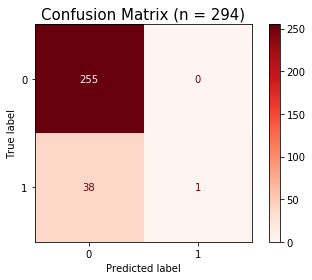

[[255   0]
 [ 38   1]]
accuracy of logistic regression is 0.87
precision of logistic regression is 1.0
recall of logistic regression is 0.03
f1 of logistic regression is 0.05


In [152]:
# 성능평가 case 02
pcm = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_test)})", fontsize=15)
plt.show()


# pcm = plot_confusion_matrix(logistic, X_test_ohe, y_test,
#                             cmap=plt.cm.Blues,
#                             ax=ax)

cm = pcm.confusion_matrix
print( cm ) 


TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[0][0]

accuracy = (TP + TN) / cm.sum()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2*precision*recall/(precision+recall)

print(f'accuracy of logistic regression is {accuracy.round(2)}')
print(f'precision of logistic regression is {precision.round(2)}')
print(f'recall of logistic regression is {recall.round(2)}')
print(f'f1 of logistic regression is {f1.round(2)}')

In [153]:
# case 03
#sklearn.metrics의 classification_report를 사용하여 정확도, 정밀도, 재현율, F1 score를 구할 수 있습니다.

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_test_pred = pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'accuracy of logistic regression is {accuracy.round(2)}')
print(f'precision of logistic regression is {precision.round(2)}')
print(f'recall of logistic regression is {recall.round(2)}')
print(f'f1 of logistic regression is {f1.round(2)}')

accuracy of logistic regression is 0.87
precision of logistic regression is 1.0
recall of logistic regression is 0.03
f1 of logistic regression is 0.05


AUC: 0.706385118149824


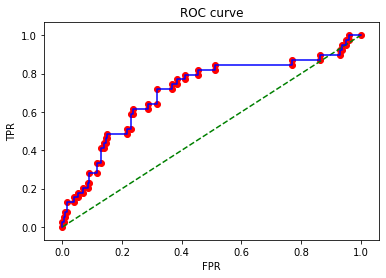

In [154]:
# 성능 점수 case 04  ( roc_auc 커브 )

from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, [0] * len(y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline")
plt.plot(fpr, tpr, color="blue", label="Model")
plt.scatter(fpr, tpr, color="red")
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# 모델 분석

## 1-1. MDI

*  high cardinality 특성에 높은 값을 부여하는 문제가 있습니다.

OverTime                0.170062
MonthlyIncome           0.141380
TotalWorkingYears       0.094474
StockOptionLevel        0.089928
YearsAtCompany          0.067495
Age                     0.061830
JobLevel                0.049725
YearsWithCurrManager    0.041182
YearsInCurrentRole      0.037797
BusinessTravel          0.027317
dtype: float64


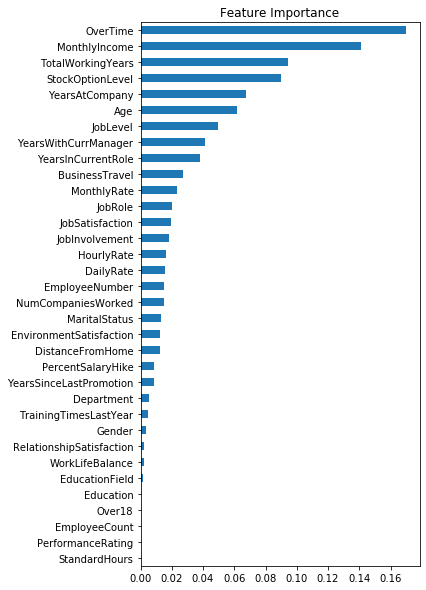

Text(0.5, 1.0, 'Cardinailty')

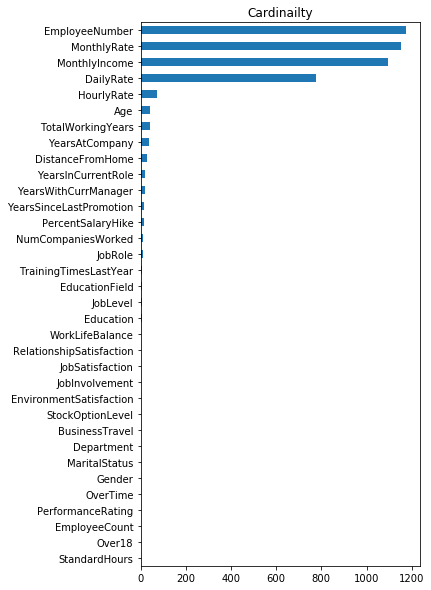

In [155]:
# 특성 중요도
rf = pipe.named_steps["randomforestclassifier"]
importances = pd.Series(rf.feature_importances_, X_train.columns)

# 결과 출력 
print( importances.sort_values(ascending= False).head(10) )

# 시각화
# MDI
#
plt.figure(figsize=(5,10)) ## Figure 생성 사이즈는 10 by 10
importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show()


# 특성 (카디날리티)
plt.figure(figsize=(5,10)) ## Figure 생성 사이즈는 10 by 10
X_train.nunique().sort_values().plot.barh()
plt.title("Cardinailty")

## 1-3. DROP-column importance 

In [156]:
# # 모든 column을 사용해 학습했을 때의 검증 정확도
# score = pipe.score(X_test, y_test)

# print(f'Before Drop :: 검증 정확도 {score:.6f}')
# dci = pd.Series(dtype=float)

# for feature in features:
#     p = get_pipeline()

#     # feature을 drop하여 모델을 재학습합니다.
#     p.fit(X_train.drop(columns=[feature], axis=1), y_train)
#     score_dropped = p.score(X_test.drop(columns=[feature], axis=1), y_test)
#     print(f"Drop {feature} :: 검증 정확도 {score_dropped:.6f}")

#     # drop-column importance는 해당 특성을 drop했을 때의 성능 하락폭으로 정의됩니다.
#     dci[feature] = score - score_dropped


# # 시각화
# dci.sort_values().plot.barh()
# plt.title("Drop-Column Importance")

### 1-2. Permutation Importance (순열 중요도)


OverTime                   0.038210
Age                        0.017094
StockOptionLevel           0.012328
EnvironmentSatisfaction    0.008748
DistanceFromHome           0.008587
JobInvolvement             0.008165
TotalWorkingYears          0.007722
JobSatisfaction            0.007682
BusinessTravel             0.006697
JobRole                    0.005691
dtype: float64


Weight,Feature
0.0382 ± 0.0328,OverTime
0.0171 ± 0.0181,Age
0.0123 ± 0.0231,StockOptionLevel
0.0087 ± 0.0048,EnvironmentSatisfaction
0.0086 ± 0.0044,DistanceFromHome
0.0082 ± 0.0055,JobInvolvement
0.0077 ± 0.0077,TotalWorkingYears
0.0077 ± 0.0067,JobSatisfaction
0.0067 ± 0.0038,BusinessTravel
0.0057 ± 0.0027,JobRole


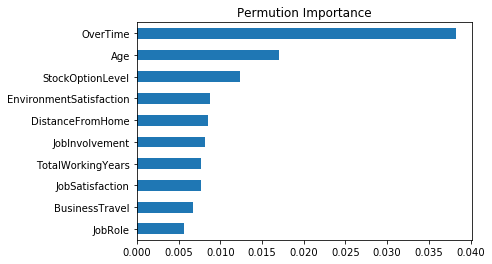

In [157]:
import eli5
from eli5.sklearn import PermutationImportance

# 순열 중요도 계산 (전체 컬럼에 대해서)
permuter = PermutationImportance(
    pipe.named_steps['randomforestclassifier'],
    scoring='roc_auc', # accuracy
    n_iter=5,
    random_state=42,
)

X_test_preprocessed = pipe[0].transform(X_test) # rf[0] : OrdinalEncoder
permuter.fit(X_test_preprocessed, y_test) # score 재계산


# 시각화 
#

feature_names = X_test.columns.tolist()
# case 01 그래프 큰게 아래쪽에 나옴
#
# pi = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
# pi.plot.barh() 
# pi.head(10).plot.barh() # 상위 10개

# case 02 그래프 큰게 위위에 나옴
#
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=True)
# pi.plot.barh() 
pi.tail(10).plot.barh() # 상위 10개

print( pi.tail(10).sort_values(ascending=False) )

# 출력
plt.title('Permution Importance')

# 특성별 score 확인
eli5.show_weights(
    permuter,
    top=None, # top n 지정 가능, None일 경우 모든 특성
    feature_names=feature_names # list 형식으로 넣어야 함
) 

In [158]:
# 상위 특성 선택
#
# score가 평균보다 큰 특성들만 사용

## 상위특성 컬럼이름 확인
sri_상위특성_col = pi[pi > pi.mean() ].sort_values( ascending=False).index
sri_상위특성_col

# 상위 특성만 사용하는 학습 , 테스트 셋 
df_x_clean = df_x_clean[sri_상위특성_col]

X_train, X_test, y_train, y_test = train_test_split( df_x_clean ,df_y_clean  , test_size=0.2, random_state=42 ) #, stratify=df_y_clean )
# X_train, X_valid, y_train, y_valid  = train_test_split(X_train_valid, y_train_valid , test_size=0.2, random_state=42  , stratify=df_y_clean )

In [159]:
# 상위 특성만 사용하는 학습 , 테스트 셋 
df_x_clean = df_x_clean[sri_상위특성_col]

X_train, X_test, y_train, y_test = train_test_split( df_x_clean ,df_y_clean  , test_size=0.2, random_state=42 ) #, stratify=df_y_clean )
# X_train, X_valid, y_train, y_valid  = train_test_split(X_train_valid, y_train_valid , test_size=0.2, random_state=42  , stratify=df_y_clean )

# 타겟 라벨 인코딩 
from sklearn.preprocessing import LabelEncoder 

# case 01
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


# 상위 특성만 사용하는 경우  학습 셋의  roc_auc 점수
pipe.fit(X_train, y_train)
y_pred_proba = pipe.predict_proba(X_test)[:,1] # 1 일 확률

roc_auc_score(y_test, y_pred_proba).round(2)

0.72

### 2. ICE plot

JobSatisfaction 범위 1 ~ 4
DistanceFromHome 범위 1 ~ 29
JobInvolvement 범위 1 ~ 4
TotalWorkingYears 범위 0 ~ 37


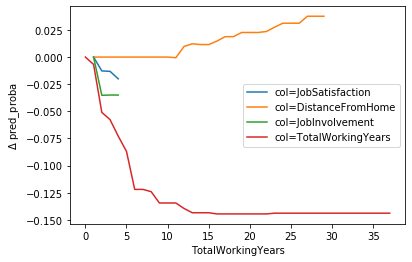

In [160]:
# ICE 플롯 그리기(100 번째 데이터의)  컬럼별 영향도(?)
# 
df_tmp = X_test
lst_target_features = [ 'JobSatisfaction' , 'DistanceFromHome' , 'JobInvolvement' , 'TotalWorkingYears' ]
lst_target_index = [100]
model = pipe

# 데이터셋(data), 분석할 데이터의 index(data_index), 변화를 확인할 특성명(target_feature), 바꿔넣어 볼 특성의 범위(target_feature_range)를 입력하면
# 해당 범위에서 모델의 예측 양상의 변화를 반환하는 함수를 작성합니다.
def get_ice_plot_data(data, data_index, target_feature, target_feature_range, model = model):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = model.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    
    return target_feature_range, results - results[0]

# 데이터 index 별
for data_index in lst_target_index:
    
    # 컬럼별
    for target_feature in lst_target_features :
        target_feature_range = range(df_tmp[target_feature].min(), df_tmp[target_feature].max() + 1)

        print( f"{target_feature} 범위 { df_tmp[target_feature].min()} ~ { df_tmp[target_feature].max() }" )
        plt.plot(
            *get_ice_plot_data( df_tmp, data_index, target_feature, target_feature_range),
            label=f"col={target_feature}",
        )
    
    plt.xlabel(target_feature)
    plt.ylabel("$\Delta$ pred_proba")
    plt.legend()

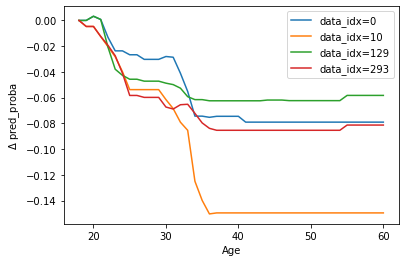

In [161]:
# 여러 인덱스의 ICE 비교

target_feature = "Age"
target_feature_range = range(X_test[target_feature].min(), X_test[target_feature].max() + 1)
for data_index in [0, 10, 129, 293]:
    plt.plot(
        *get_ice_plot_data(
            X_test, data_index, target_feature, target_feature_range
        ),
        label=f"data_idx={data_index}",
    )
    # print ( *get_ice_plot_data(X_val_encoded, data_index, target_feature, target_feature_range)  )

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred_proba")
plt.legend()

2.2 PDP PLOT

100%|██████████| 294/294 [00:06<00:00, 45.80it/s]

(294, 4)
(4,)


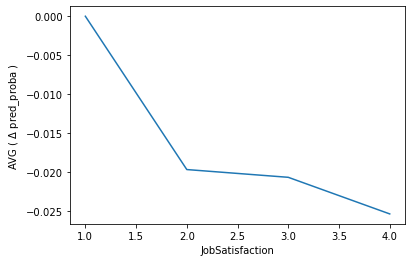

In [162]:
df_tmp = X_test
target_feature = "JobSatisfaction"
target_feature_range = target_feature_range = range(df_tmp[target_feature].min(), df_tmp[target_feature].max() + 1)

# PDP Plot 그리기
#

from tqdm import tqdm
all_ice_plot_data = []

# 모든 검증 데이터에 대해 우리가 작성한 함수로 ICE plot 데이터를 계산합니다.
for data_index in tqdm(range(len(df_tmp))):
    all_ice_plot_data.append(
        get_ice_plot_data(
            df_tmp, data_index, target_feature, target_feature_range
        )[1]
    )


# 시각화
all_ice_plot_data = np.array(all_ice_plot_data)
print(all_ice_plot_data.shape)

# 6033개의 ICE plot data를 0번째(data index) 축으로 평균합시다.
pdp_data = all_ice_plot_data.mean(0)
print(pdp_data.shape)

# PDP(평균 ICE plot) data를 시각화해 봅시다.
plt.plot(target_feature_range, pdp_data)
plt.xlabel(target_feature)
plt.ylabel("AVG ( $\Delta$ pred_proba ) ")
plt.show()

In [163]:
# # PDP box를 이용한 pdp 그리기


# from pdpbox.pdp import pdp_isolate, pdp_plot

# target_feature = "Age"

isolated = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=target_feature,
    grid_type="percentile",  # default = 'percentile', or 'equal'
    num_grid_points=10,  # default = 10
)
# pdp_plot(isolated, feature_name=target_feature)

# pdp_plot(
#     isolated,
#     feature_name=target_feature,
#     plot_lines=True,  # ICE plots
#     frac_to_plot=50,  # float type을 입력하면 전체 데이터 갯수 중 plotting할 데이터 수의 비율이 됩니다. int type을 입력하면 데이터의 수가 됩니다.
#     plot_pts_dist=True,
# )

In [180]:
X_val_encoded

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week
217,2,11,4,10,3,1,1,1,28,0,0,55
24913,2,5,1,4,1,2,1,20,41,0,0,40
17780,2,5,1,9,1,1,1,12,53,0,0,50
12484,2,5,1,4,1,1,1,1,31,0,0,45
8890,5,2,6,10,3,1,2,1,34,0,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...
25768,2,5,3,3,4,2,2,1,28,0,0,40
25057,2,3,1,4,1,1,1,1,28,0,0,40
26286,2,2,1,2,1,1,1,1,47,0,0,40
3418,2,5,1,7,1,1,1,1,46,0,0,40


salary before preprocessing [' <=50K' ' >50K']
salary after preprocessing [False  True]
[11:43:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.59355	validation_1-logloss:0.59395
[1]	validation_0-logloss:0.52522	validation_1-logloss:0.52638
[2]	validation_0-logloss:0.48061	validation_1-logloss:0.48254
[3]	validation_0-logloss:0.44375	validation_1-logloss:0.44574
[4]	validation_0-logloss:0.41607	validation_1-logloss:0.41883
[5]	validation_0-logloss:0.39623	validation_1-logloss:0.40059
[6]	validation_0-logloss:0.37887	validation_1-logloss:0.38375
[7]	validation_0-logloss:0.36212	validation_1-logloss:0.36742
[8]	validation_0-logloss:0.34992	validation_1-logloss:0.

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2816a2430>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2817097c0>})

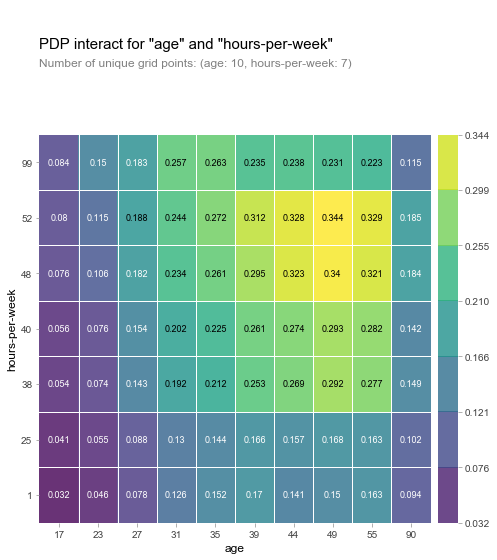

In [179]:

data = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/census_income.csv")
# 결측치가 있는 row를 drop하고 salary를 범주형으로 변환합니다.
data = data.replace(" ?", np.nan).dropna().reset_index(drop=True)
print("salary before preprocessing", data["salary"].unique())
data["salary"] = data["salary"].str.strip().apply(lambda x: x == ">50K")
print("salary after preprocessing", data["salary"].unique())
# 학습과 검증 데이터셋을 분리합니다.
train, val = train_test_split(data, test_size=0.2, random_state=42)
# 사용할 특성 및 타겟을 선택합니다.
cat_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]
num_featuers = ["age", "capital-gain", "capital-loss", "hours-per-week"]
target = "salary"
# 특성과 타겟을 분리합니다.
X_train = train[cat_features + num_featuers]
y_train = train[target]
X_val = val[cat_features + num_featuers]
y_val = val[target]

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)  # 학습데이터
X_val_encoded = encoder.transform(X_val)  # 검증데이터



boosting = XGBClassifier(
    n_estimators=1000,
    objective="binary:logistic",  # default
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, eval_set=eval_set, early_stopping_rounds=50)

from pdpbox.pdp import pdp_interact, pdp_interact_plot

target_features = ["age", "hours-per-week"]

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=target_features,
)

pdp_interact_plot(interaction, plot_type="grid", feature_names=target_features)


In [164]:
# (v)
# # 컬럼 이름 -> 카테고리 맵핑 정보 하기


# # 카테고리 맵핑 데이터를 만들 컬럼 조회 , 지정
# categorical_columns = list(df.select_dtypes(['category']).columns.append( df.select_dtypes(['object']).columns ) )
# # 컬럼을 카테고리 타입으로 변환
# df[categorical_columns] = df[categorical_columns].astype('category')
# # categorical_columns = lst_category_순서_num
# # 카테고리 값은 숫자,알파벳 순으로 기 정렬되어 이를 그대로 이용함
# category_mapping = [{'col': column_name, 'mapping': dict (zip(df[column_name].cat.categories, [ x for x in range(0,len(df[column_name].cat.categories) )] ))} 
# for column_name in categorical_columns]

# # 변경할 카테고리 순서 정보
# category_mapping_tmp = [{ 'col': 'shot_zone_range',
#                     'mapping': {
#                         'Less Than 8 ft.' : 0 ,
#                         '8-16 ft.' : 1 ,
#                         '16-24 ft.' : 2 ,
#                         '24+ ft.' : 3 ,
#                         'Back Court Shot' : 4 ,    
#                     }}]

# # 새로 추가할 컬럼에 해당하는 mapping 정보를 삭제
# del_col_name = 'shot_zone_range'
# for i , dic_tmp in enumerate(category_mapping) :
#     col_name = dic_tmp['col']
#     print ( col_name )
#     if col_name == del_col_name :
#         #lst_del_index.append(i)
#         del category_mapping[i]
#         break


# # 카테고리 맵핑에 새로운 맵핑 정보를 추가
# category_mapping = category_mapping + category_mapping_tmp




# # 적용

# #lsp
# pipe = make_pipeline(
#     OrdinalEncoder( cols=categorical_columns, mapping=category_mapping ),
#     # OrdinalEncoder( ),
#     SimpleImputer(strategy="mean"),
#     XGBClassifier(
#         objective="binary:logistic",
#         eval_metric="error",
#         n_estimators=2000,
#         random_state=42,
#         n_jobs=-1,
#         learning_rate=0.01,
#         use_label_encoder=False,
#         # scale_pos_weight= 
#     ),
# )
# print(pipe)




# 타겟 불균형 해소

선형 회귀 모델은 특성 변수들에 따른 타겟변수의 분포가 정규분포 형태일때 좋은 성능을 보입니다.  

log1p: ln(1 + x)  
expm1: exp(x) - 1, the inverse of log1p.

In [165]:
df = pd.read_csv(
    "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/house-prices/house_prices_train.csv"
)
target = "SalePrice"


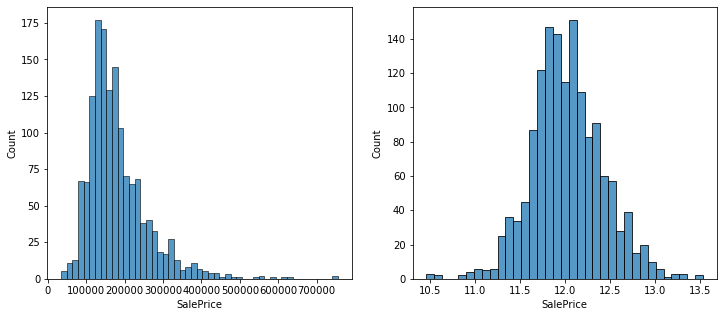

In [166]:
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df[target], ax=ax[0])
sns.histplot(np.log1p(df[target]), ax=ax[1])

In [167]:
# TransformedTargetRegressor 사용하여 타겟 불균형 해소

features = ["BldgType", "CentralAir", "FullBath", "GrLivArea", "LotArea", "OverallCond", "OverallQual", "TotRmsAbvGrd", "YearBuilt", "YrSold", ]


from sklearn.model_selection import train_test_split

df = df.dropna(subset=[target])
train, val = train_test_split(df, test_size=0.2, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]


from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(OrdinalEncoder(), SimpleImputer(), LinearRegression())
pipe.fit(X_train, y_train)

# 불균형 해소전 스코어
print( pipe.score(X_val, y_val) )


# TransformedTargetRegressor 사용하여 불균형 해소
trans_target_reg = TransformedTargetRegressor(
    regressor=pipe, func=np.log1p, inverse_func=np.expm1
)
trans_target_reg.fit(X_train, y_train)

# 불균형 해소휴 스코어
trans_target_reg.score(X_val, y_val)


0.7765272770014873


0.8441487230508911

In [168]:
df = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/fraud_oracle.csv")
target = "FraudFound_P"

df = df.drop(columns=["PolicyNumber", "Year"])

train, val = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_val, y_val = val.drop(columns=[target]), val[target]


from category_encoders import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)


from xgboost import XGBClassifier

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)
print(model)



watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=987654321, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
[0]	validation_0-auc:0.82236	validation_1-auc:0.81901
[1]	validation_0-auc:0.82870	validation_1-auc:0.82024
[2]	validation_0-auc:0.83006	validation_1-auc:0.82164
[3]	validation_0-auc:0.83012	validation_1-auc:0.82098
[4]	validation_0-auc:0.83101	validation_1-auc:0.82076
[5]	validation_0-auc:0.8337

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=987654321, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

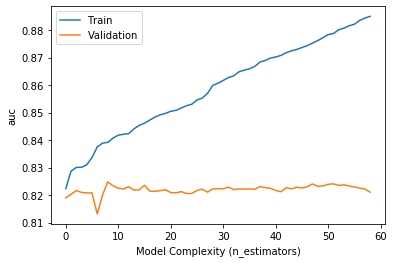

검증 정확도 0.9409857328145266
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.67      0.02      0.04       185

    accuracy                           0.94      3084
   macro avg       0.80      0.51      0.51      3084
weighted avg       0.92      0.94      0.91      3084

ROC-AUC: 0.8199668105497703


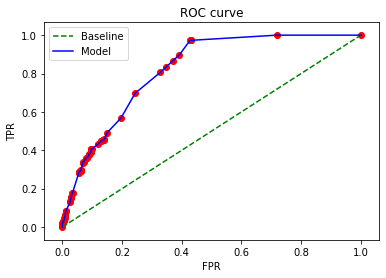

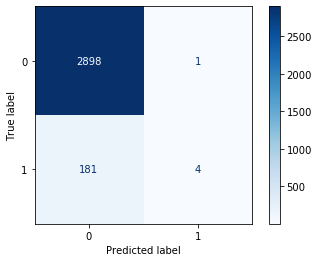

In [169]:
def summarize_results(model, X_val_encoded, y_val):
    # 1. Train / Val Loss Plot
    if isinstance(model, XGBClassifier):
        results = model.evals_result()
        tgts = results["validation_0"].keys()

        for tgt in tgts:
            train_error = results["validation_0"][tgt]
            val_error = results["validation_1"][tgt]

            plt.plot(train_error, label="Train")
            plt.plot(val_error, label="Validation")
            plt.ylabel(tgt)
            plt.xlabel("Model Complexity (n_estimators)")
            plt.legend()
            plt.show()

    # 2. Accuracy / Classification Report
    print("검증 정확도", model.score(X_val_encoded, y_val))

    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)

    print(classification_report(y_val, y_pred))

    # 3. ROC-AUC
    def get_roc_auc(model, X_val_encoded, y_val):
        if isinstance(model, XGBClassifier):
            y_pred_proba = model.predict_proba(
                X_val_encoded, iteration_range=(0, model.best_iteration)
            )[:, 1]
        else:
            y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

        print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))

        baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds': thresholds})
        plt.plot(
            baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline"
        )
        plt.plot(fpr, tpr, color="blue", label="Model")
        plt.scatter(fpr, tpr, color="red")
        plt.legend()
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()
        return tmp

    get_roc_auc(model, X_val_encoded, y_val)

    # 4. Confusion Matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(model, X_val_encoded, y_val,cmap='Blues')
    plt.show()

#성능지표
summarize_results(model, X_val_encoded, y_val)

### Class Weight

[0]	validation_0-auc:0.83434	validation_1-auc:0.81445
[1]	validation_0-auc:0.83916	validation_1-auc:0.82186
[2]	validation_0-auc:0.84068	validation_1-auc:0.82422
[3]	validation_0-auc:0.84369	validation_1-auc:0.82241
[4]	validation_0-auc:0.84471	validation_1-auc:0.82235
[5]	validation_0-auc:0.84642	validation_1-auc:0.82144
[6]	validation_0-auc:0.84788	validation_1-auc:0.82102
[7]	validation_0-auc:0.84857	validation_1-auc:0.82012
[8]	validation_0-auc:0.84925	validation_1-auc:0.82103
[9]	validation_0-auc:0.85083	validation_1-auc:0.81990
[10]	validation_0-auc:0.85290	validation_1-auc:0.81946
[11]	validation_0-auc:0.85450	validation_1-auc:0.82083
[12]	validation_0-auc:0.85578	validation_1-auc:0.82052
[13]	validation_0-auc:0.85647	validation_1-auc:0.82183
[14]	validation_0-auc:0.85774	validation_1-auc:0.82076
[15]	validation_0-auc:0.85828	validation_1-auc:0.81955
[16]	validation_0-auc:0.86057	validation_1-auc:0.81873
[17]	validation_0-auc:0.86127	validation_1-auc:0.81997
[18]	validation_0-au

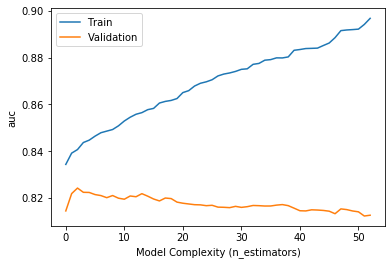

검증 정확도 0.6303501945525292
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      2899
           1       0.13      0.88      0.22       185

    accuracy                           0.64      3084
   macro avg       0.56      0.75      0.49      3084
weighted avg       0.94      0.64      0.73      3084

ROC-AUC: 0.8218556258915003


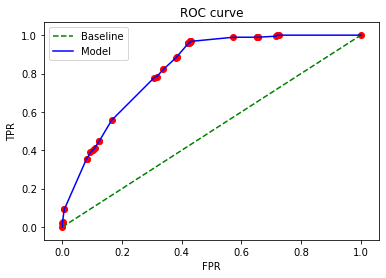

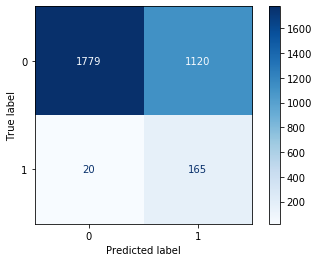

In [170]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),
)

watchlist = [(X_train_encoded, y_train), (X_val_encoded, y_val)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

#성능지표
summarize_results(model, X_val_encoded, y_val)

### Undersampling

0    738
1    738
Name: FraudFound_P, dtype: int64
[0]	validation_0-auc:0.84146	validation_1-auc:0.80548
[1]	validation_0-auc:0.84545	validation_1-auc:0.80839
[2]	validation_0-auc:0.84752	validation_1-auc:0.81084
[3]	validation_0-auc:0.85192	validation_1-auc:0.81892
[4]	validation_0-auc:0.86051	validation_1-auc:0.81785
[5]	validation_0-auc:0.86292	validation_1-auc:0.81678
[6]	validation_0-auc:0.86505	validation_1-auc:0.81782
[7]	validation_0-auc:0.86654	validation_1-auc:0.81828
[8]	validation_0-auc:0.87012	validation_1-auc:0.81947
[9]	validation_0-auc:0.87476	validation_1-auc:0.82031
[10]	validation_0-auc:0.87498	validation_1-auc:0.81572
[11]	validation_0-auc:0.87692	validation_1-auc:0.81888
[12]	validation_0-auc:0.87932	validation_1-auc:0.82111
[13]	validation_0-auc:0.88421	validation_1-auc:0.81981
[14]	validation_0-auc:0.88594	validation_1-auc:0.82073
[15]	validation_0-auc:0.88724	validation_1-auc:0.82138
[16]	validation_0-auc:0.88994	validation_1-auc:0.82096
[17]	validation_0-auc:0.

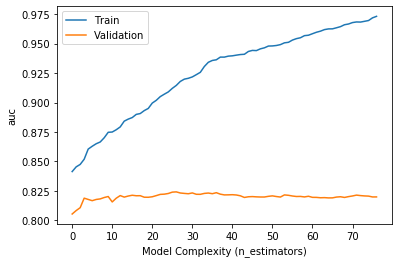

검증 정확도 0.6245136186770428
              precision    recall  f1-score   support

           0       0.99      0.60      0.75      2899
           1       0.13      0.95      0.23       185

    accuracy                           0.62      3084
   macro avg       0.56      0.77      0.49      3084
weighted avg       0.94      0.62      0.72      3084

ROC-AUC: 0.8240222630357159


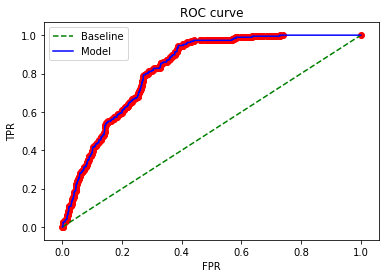

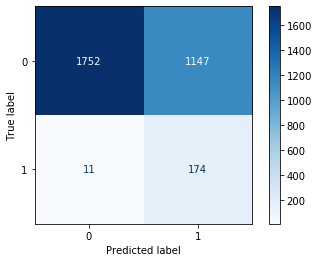

In [171]:
from imblearn.under_sampling import RandomUnderSampler


X_train_sampled, y_train_sampled = RandomUnderSampler(random_state=42).fit_resample(
    X_train_encoded, y_train
)
# Undersampling 시 각 class의 샘플들이 동일한 비율로 샘플링된 것을 볼 수 있습니다.
print( y_train_sampled.value_counts() )

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)


watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

#성능지표
summarize_results(model, X_val_encoded, y_val)


### Oversampling

0    11598
1    11598
Name: FraudFound_P, dtype: int64
[0]	validation_0-auc:0.87760	validation_1-auc:0.77711
[1]	validation_0-auc:0.88557	validation_1-auc:0.77809
[2]	validation_0-auc:0.90162	validation_1-auc:0.77414
[3]	validation_0-auc:0.90342	validation_1-auc:0.77543
[4]	validation_0-auc:0.91713	validation_1-auc:0.77857
[5]	validation_0-auc:0.92188	validation_1-auc:0.77560
[6]	validation_0-auc:0.92163	validation_1-auc:0.77479
[7]	validation_0-auc:0.92384	validation_1-auc:0.77546
[8]	validation_0-auc:0.92558	validation_1-auc:0.77922
[9]	validation_0-auc:0.92551	validation_1-auc:0.77763
[10]	validation_0-auc:0.92644	validation_1-auc:0.77625
[11]	validation_0-auc:0.92892	validation_1-auc:0.77819
[12]	validation_0-auc:0.93598	validation_1-auc:0.78047
[13]	validation_0-auc:0.93561	validation_1-auc:0.78045
[14]	validation_0-auc:0.93727	validation_1-auc:0.78002
[15]	validation_0-auc:0.93803	validation_1-auc:0.77772
[16]	validation_0-auc:0.93910	validation_1-auc:0.77880
[17]	validation_0-au

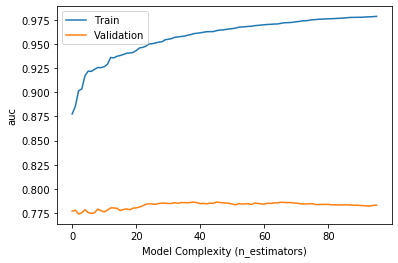

검증 정확도 0.8057717250324254
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      2899
           1       0.14      0.44      0.21       185

    accuracy                           0.81      3084
   macro avg       0.55      0.64      0.55      3084
weighted avg       0.91      0.81      0.85      3084

ROC-AUC: 0.785112294080904


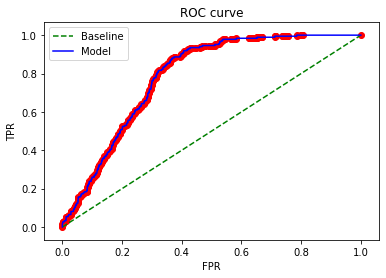

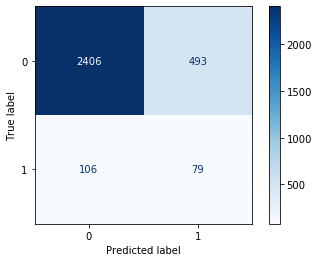

In [172]:
from imblearn.over_sampling import SMOTE


model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
)

X_train_sampled, y_train_sampled = SMOTE(random_state=42).fit_resample(
    X_train_encoded, y_train
)
print( y_train_sampled.value_counts() )

watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

#성능지표
summarize_results(model, X_val_encoded, y_val)


### Oversampling + Undersapmling

1    11575
0     6777
Name: FraudFound_P, dtype: int64
[08:27:16] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.89297	validation_1-auc:0.77613
[1]	validation_0-auc:0.89595	validation_1-auc:0.77168
[2]	validation_0-auc:0.91558	validation_1-auc:0.77248
[3]	validation_0-auc:0.92939	validation_1-auc:0.78054
[4]	validation_0-auc:0.92888	validation_1-auc:0.77755
[5]	validation_0-auc:0.93317	validation_1-auc:0.77868
[6]	validation_0-auc:0.93550	validation_1-auc:0.77955
[7]	validation_0-auc:0.93503	validation_1-auc:0.77771
[8]	validation_0-auc:0.93637	validation_1-auc:0

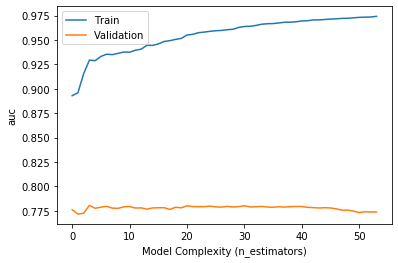

검증 정확도 0.7295719844357976
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      2899
           1       0.13      0.62      0.21       185

    accuracy                           0.72      3084
   macro avg       0.55      0.67      0.52      3084
weighted avg       0.92      0.72      0.79      3084

ROC-AUC: 0.7724816572350205


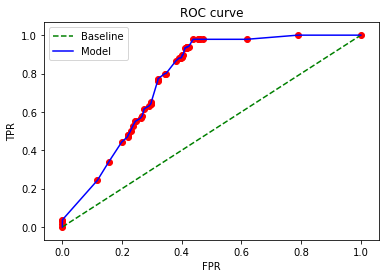

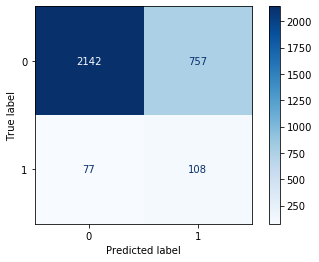

In [173]:
from imblearn.combine import SMOTEENN

X_train_sampled, y_train_sampled = SMOTEENN(random_state=42).fit_resample(
    X_train_encoded, y_train
)
print( y_train_sampled.value_counts() )

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=987654321,
    random_state=42,
    n_jobs=-1,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(y_train_sampled == 0).sum() / (y_train_sampled == 1).sum(),
)

watchlist = [(X_train_sampled, y_train_sampled), (X_val_encoded, y_val)]

model.fit(
    X_train_sampled,
    y_train_sampled,
    eval_set=watchlist,
    early_stopping_rounds=50,  # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

#성능지표
summarize_results(model, X_val_encoded, y_val)

In [174]:
# 팁



In [175]:
def 단순다중선형회귀 ( df , feature , target , fit = True , simple_ols=None) :

    X = df[feature]
    y = df[target]

    # 모델을 학습합니다.
    if fit :
      simple_ols = LinearRegression()
      simple_ols.fit(X, y)

    # 회귀 모델의 y 값 조회
    interpolate_y = simple_ols.predict(X)

    # 선형회귀 계수 값 확인
    # 회귀계수(coefficient) , ## 절편(intercept)
    print('coefficient : ', simple_ols.coef_  , 'Intercept : ', simple_ols.intercept_) 

    return simple_ols , interpolate_y

# 다항 선형회귀
def 다항선형회귀(df , feature , target , degree=2, fit = True , poly_ols = None,  **kwargs):

    X = df[feature]
    y = df[target]
  
    # 모델을 학습합니다.
    if fit :
      poly_ols = make_pipeline(PolynomialFeatures(degree), 
                              LinearRegression(**kwargs))
      poly_ols.fit(X, y)

     # 회귀 모델의 y 값 조회
    interpolate_y = poly_ols.predict(X)

     # 선형회귀 계수 값 확인
    # 회귀계수(coefficient) , ## 절편(intercept)
    #print('coefficient : ', poly_ols.coef_  , 'Intercept : ', poly_ols.intercept_) 

    return poly_ols , interpolate_y


df_kc_house_data = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/kc_house_data/kc_house_data.csv')

df = df_kc_house_data
target = 'price'


df_y_clean = df[target]
df_x_clean = df.drop( columns=[target] )
X_train, X_test, y_train, y_test = train_test_split( df_x_clean ,df_y_clean  , test_size=0.2, random_state=42 ) #, stratify=df_y_clean )
# X_train, X_valid, y_train, y_valid  = train_test_split(X_train_valid, y_train_valid , test_size=0.2, random_state=42  , stratify=df_y_clean )


# 구하고자 하는 목표 값 컬럼

# 상관계수가 높은 컬럼 확인
lst_corr_colname = df.corr(method='pearson', min_periods=1)[target].sort_values(ascending=False)[1:]
print( f" lst_corr_colname = \n{lst_corr_colname}" )   # 목표값 컬럼과 상관계수가 높은 컬럼 ( desc ) 

# 다중 선형회귀
feature = lst_corr_colname.index[:6]  # sqft_living , ....
multiple_ols , y_all_multiple = 단순다중선형회귀 ( df , feature , target ) 



 lst_corr_colname = 
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64
coefficient :  [ 2.07864655e+02  1.03243662e+05 -4.22179456e+01  4.03023081e+00
 -2.96160142e+04  9.18553078e+04] Intercept :  -574168.543772109


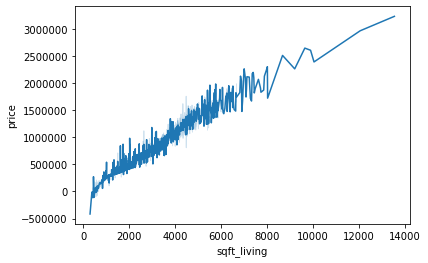

In [176]:

df_tmp = df[feature]
df_tmp[target] = y_all_multiple
sns.lineplot( data = df_tmp , x ='sqft_living' , y='price' )
df_tmp.drop( columns=['price'] , inplace= True)

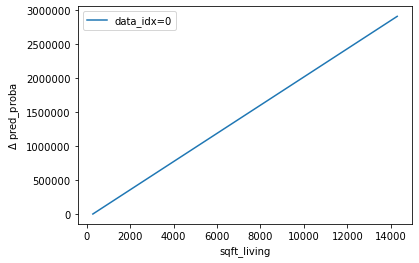

In [177]:
def get_ice_plot_data_4_reg(data, data_index, target_feature, target_feature_range, model):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = model.predict(one_datapoint)
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    return target_feature_range, results - results[0]


target_feature = "sqft_living"
from numpy import arange
step = 1000
target_feature_range = arange(df_tmp["sqft_living"].min(), df_tmp["sqft_living"].max() + step, step)
for data_index in [0]:
    plt.plot(
        *get_ice_plot_data_4_reg(
            df_tmp, data_index, target_feature, target_feature_range
            ,multiple_ols
        ),
        label=f"data_idx={data_index}",
    )
    # print ( *get_ice_plot_data(X_val_encoded, data_index, target_feature, target_feature_range)  )

plt.xlabel(target_feature)
plt.ylabel("$\Delta$ pred_proba")
plt.legend()